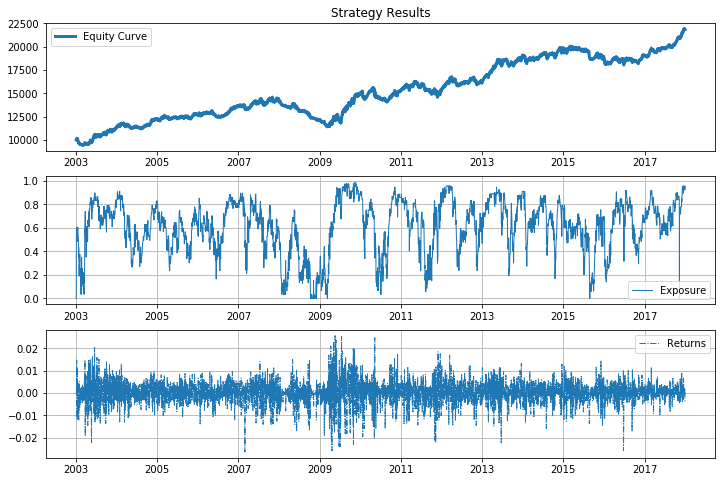

In [22]:
# This ensures that our graphs will be shown properly in the notebook.
%matplotlib inline

# Import a few libraries we need
from zipline import run_algorithm

from zipline.api import order_target_percent, record, symbol
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd

def initialize(context):
    # Which stock to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # Make a list of symbols from the list of tickers
    context.dji_symbols = [symbol(s) for s in dji]
    
    # Moving average window
    context.index_average_window = 100
    
def handle_data(context, data):
    # Get history for all the stocks
    stock_hist = data.history(context.dji_symbols, "close", context.index_average_window, "1d")
    
    # Make an empty DataFrame to start with
    stock_analytics = pd.DataFrame()
    
    # Add column for above or below average
    stock_analytics['above_mean'] = stock_hist.iloc[-1] > stock_hist.mean() 
    
    # Set weight for stocks to buy
    stock_analytics.loc[stock_analytics['above_mean'] == True, 'weight'] = 1/len(context.dji_symbols)
    
    # Set weight to zero for the rest
    stock_analytics.loc[stock_analytics['above_mean'] == False, 'weight'] = 0.0
    
    # Iterate each row and place trades
    for stock, analytics in stock_analytics.iterrows():
        # Check if the stock can be traded
        if data.can_trade(stock):
            # Place the trade
            order_target_percent(stock, analytics['weight'])

def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.plot(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)

# Set start and end date
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(start=start, end=end, 
                                initialize=initialize, analyze=analyze, 
                                handle_data=handle_data, 
                                capital_base=10000, 
                                data_frequency = 'daily', bundle='quandl' ) 
